# 利用 Apriori 演算法觀察加密貨幣之間報酬率的關係
* 總共 60 種加密貨幣
* 2019/9/1 ~ 2020/9/30 幣安現貨資料

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from apyori import apriori

In [2]:
path = os.getcwd()

In [3]:
df = pd.read_csv(path + '/crypto_data.csv', index_col = 'Datetime', parse_dates = True)
df.head(2)

,BTCUSDT,ETHUSDT,BNBUSDT,NEOUSDT,LTCUSDT,ADAUSDT,XRPUSDT,EOSUSDT,TUSDUSDT,IOTAUSDT,...,MTLUSDT,TOMOUSDT,PERLUSDT,DENTUSDT,MFTUSDT,KEYUSDT,DOCKUSDT,WANUSDT,FUNUSDT,CVCUSDT
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-01 00:00:00,9617.06,172.45,21.3579,8.828,64.70,0.04495,0.25837,3.3235,0.9995,0.2477,...,0.4065,0.4715,0.0869,0.000461,0.001042,0.001425,0.006412,0.3422,0.002698,0.04071
2019-09-01 01:00:00,9614.99,172.71,21.4553,8.830,64.66,0.04504,0.25754,3.3259,0.9988,0.2478,...,0.4050,0.4756,0.0869,0.000461,0.001047,0.001425,0.006400,0.3381,0.002723,0.04089


In [4]:
df.shape

(18251, 60)

In [5]:
# 是否有缺漏值
df.isnull().any().all()

False

In [6]:
# 計算報酬率

## log return
log_ret = np.log(df/df.shift(1))[1:]

## simple return
simple_ret = df.pct_change()[1:]

In [7]:
def tidy_data(threshold, df_ret = log_ret):
    
    crypto_name = [i[:-4] for i in df_ret.columns]
    arr = np.array(df_ret)
    records = []

    for each_row in arr:
        inner_list = []
        for ret,name in zip(each_row,crypto_name):
            if ret >= threshold:
                inner_list.append(name+'_upper')
            elif ret <= -threshold:
                inner_list.append(name+'_lower')
        records.append(inner_list)
    return records

In [8]:
records = tidy_data(threshold = 0.01, df_ret = log_ret)

In [14]:
records[0]

['THETA_lower', 'ENJ_upper', 'ANKR_lower', 'COCOS_lower', 'WAN_lower']

In [15]:
len(records)

18250

In [10]:
times = []
for i in np.linspace(0.001, 0.03, num = 30):
    records = tidy_data(threshold = i, df_ret = log_ret)
    avg = np.mean([len(j) for j in records])
    times.append({'threshold':i, 'avg':avg})

In [11]:
times = pd.DataFrame(times)

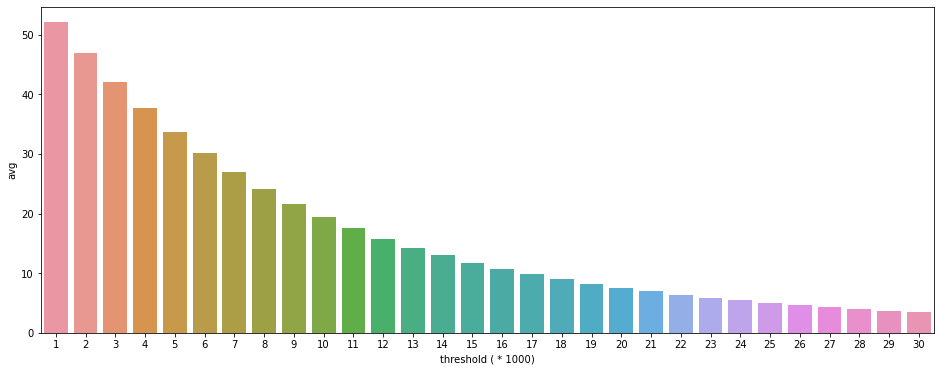

In [12]:
plt.figure(figsize=(16,6))
plt.xlabel('threshold ( * 1000)')
threshold_multiply_by1000 = [int(t*1000) for t in times['threshold']]
sns.barplot(x = threshold_multiply_by1000, y = times['avg']);

## Apply algorithm
min_support 設得太低，會完全跑不出來！

* threshold = 0.0006

In [13]:
records = tidy_data(threshold = 0.006, df_ret = log_ret)

In [14]:
association_rule = apriori(records, min_support = 0.16, min_confidence = 0.6, min_lift = 2.5)
association_results = list(association_rule)

In [15]:
count = 0
for item in association_results:
    #[2][0][0]=>item base   
    for item_num in range(0,len(item[2])):
        if item[2][item_num][0] == frozenset():
            continue
        else:
            pairBase = item[2][item_num][0] 
            items = [x for x in pairBase]
            r="Rule: ("
            for x in range(0,len(items)):
                if x==0 :
                    r=r+items[x]
                else:
                    r=r+", "+items[x]
            r=r+") -> "
            #[2][0][1]=>item add  
            pairAdd = item[2][item_num][1]
            items = [x for x in pairAdd]
            
            for x in range(0, len(items)):
                if x==0 :
                    r=r+"("+items[x]
                else:
                    r=r+", "+items[x]
            r=r+")"

            #print rule
            print(r)
            #[0] => all items in the rule
            print("Length: "+str(len(item[0])))
            #[1] => support
            print("Support: " + str(item[1]))
            #[2][0][2] => confidence
            print("Confidence: " + str(item[2][item_num][2]))
            #[2][0][3] => lift
            print("Lift: " + str(item[2][item_num][3]))
            print("=====================================")
            count=count+1
print("count=", count)

Rule: (BAT_lower) -> (ONT_lower)
Length: 2
Support: 0.16065753424657533
Confidence: 0.637391304347826
Lift: 2.5453810293977734
Rule: (ONT_lower) -> (BAT_lower)
Length: 2
Support: 0.16065753424657533
Confidence: 0.6415754923413567
Lift: 2.5453810293977734
Rule: (IOST_lower) -> (ONT_lower)
Length: 2
Support: 0.16526027397260273
Confidence: 0.6440316036728593
Lift: 2.571898636111528
Rule: (ONT_lower) -> (IOST_lower)
Length: 2
Support: 0.16526027397260273
Confidence: 0.6599562363238513
Lift: 2.5718986361115284
Rule: (LINK_lower) -> (NEO_lower)
Length: 2
Support: 0.16087671232876713
Confidence: 0.6164182238085241
Lift: 2.5974676944136608
Rule: (NEO_lower) -> (LINK_lower)
Length: 2
Support: 0.16087671232876713
Confidence: 0.6779034864927269
Lift: 2.5974676944136608
Rule: (NEO_lower) -> (ONT_lower)
Length: 2
Support: 0.17084931506849316
Confidence: 0.7199261140614177
Lift: 2.874978464249644
Rule: (ONT_lower) -> (NEO_lower)
Length: 2
Support: 0.17084931506849316
Confidence: 0.6822757111597375


* threshold = 0.001

In [16]:
records = tidy_data(threshold = 0.01, df_ret = log_ret)

In [17]:
association_rule = apriori(records, min_support = 0.105, min_confidence = 0.5, min_lift = 2)
association_results = list(association_rule)

In [18]:
count = 0
for item in association_results:
    #[2][0][0]=>item base   
    for item_num in range(0,len(item[2])):
        if item[2][item_num][0] == frozenset():
            continue
        else:
            pairBase = item[2][item_num][0] 
            items = [x for x in pairBase]
            r="Rule: ("
            for x in range(0,len(items)):
                if x==0 :
                    r=r+items[x]
                else:
                    r=r+", "+items[x]
            r=r+") -> "
            #[2][0][1]=>item add  
            pairAdd = item[2][item_num][1]
            items = [x for x in pairAdd]
            
            for x in range(0, len(items)):
                if x==0 :
                    r=r+"("+items[x]
                else:
                    r=r+", "+items[x]
            r=r+")"

            #print rule
            print(r)
            #[0] => all items in the rule
            print("Length: "+str(len(item[0])))
            #[1] => support
            print("Support: " + str(item[1]))
            #[2][0][2] => confidence
            print("Confidence: " + str(item[2][item_num][2]))
            #[2][0][3] => lift
            print("Lift: " + str(item[2][item_num][3]))
            print("=====================================")
            count=count+1
print("count=", count)

Rule: (ALGO_lower) -> (ATOM_lower)
Length: 2
Support: 0.10652054794520548
Confidence: 0.5440806045340051
Lift: 3.000746761180294
Rule: (ATOM_lower) -> (ALGO_lower)
Length: 2
Support: 0.10652054794520548
Confidence: 0.5874886672710788
Lift: 3.000746761180294
Rule: (ALGO_lower) -> (FTM_lower)
Length: 2
Support: 0.10827397260273973
Confidence: 0.5530366638678982
Lift: 2.418044828842631
Rule: (CELR_lower) -> (FET_lower)
Length: 2
Support: 0.10690410958904109
Confidence: 0.5016713808176909
Lift: 2.2314166950823444
Rule: (CELR_lower) -> (ONE_lower)
Length: 2
Support: 0.11063013698630136
Confidence: 0.519156595525842
Lift: 2.513158585768333
Rule: (ONE_lower) -> (CELR_lower)
Length: 2
Support: 0.11063013698630136
Confidence: 0.5355437665782493
Lift: 2.5131585857683336
Rule: (ENJ_lower) -> (FTM_lower)
Length: 2
Support: 0.10504109589041095
Confidence: 0.541831543244771
Lift: 2.3690526267889487
Rule: (FET_lower) -> (FTM_lower)
Length: 2
Support: 0.1141917808219178
Confidence: 0.5079210333902023


## 參數最佳化
跑一次太久了（若 Support 設定太低的值），可能沒辦法做到最佳化

In [19]:
def countRuleNum(association_results, output=True):

    count = 0
    for item in association_results:
        #[2][0][0]=>item base   
        for item_num in range(0,len(item[2])):
            if item[2][item_num][0] == frozenset():
                continue
            else:
                if output:
                    pairBase = item[2][item_num][0] 
                    items = [x for x in pairBase]
                    r="Rule: ("
                    for x in range(0,len(items)):
                        if x==0 :
                            r=r+items[x]
                        else:
                            r=r+", "+items[x]
                    r=r+") -> "
                    #[2][0][1]=>item add  
                    pairAdd = item[2][item_num][1]
                    items = [x for x in pairAdd]

                    for x in range(0, len(items)):
                        if x==0 :
                            r=r+"("+items[x]
                        else:
                            r=r+", "+items[x]
                    r=r+")"

                    #print rule
                    print(r)
                    #[0] => all items in the rule
                    print("Length: "+str(len(item[0])))
                    #[1] => support
                    print("Support: " + str(item[1]))
                    #[2][0][2] => confidence
                    print("Confidence: " + str(item[2][item_num][2]))
                    #[2][0][3] => lift
                    print("Lift: " + str(item[2][item_num][3]))
                    print("=====================================")
                count=count+1
    return count

In [20]:
# count = []

# for i in np.arange(0.001, 0.602, 0.005):
#     association_rules = apriori(records, min_support=i, min_confidence=0.2, min_lift=3)
#     association_results = list(association_rules)
#     relation = countRuleNum(association_results, output=False)
    
#     count.append({'min_support':i, 'relation':relation})
    
# count = pd.DataFrame(count)